### Build a predictive model for Tesla Stock Price data. We will use OHLC(‘Open’, ‘High’, ‘Low’, ‘Close’) data from 1st January 2010 to 31st December 2017 which is for 8 years for the Tesla stocks.

In [1]:
!pip install xgboost

  Using cached xgboost-2.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.1-py3-none-win_amd64.whl (124.9 MB)


In [2]:
!pip install --upgrade scikit-learn

  Using cached scikit_learn-1.5.1-cp311-cp311-win_amd64.whl.metadata (12 kB)
Using cached scikit_learn-1.5.1-cp311-cp311-win_amd64.whl (11.0 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Admin\\Documents\\anaconda\\Lib\\site-packages\\sklearn\\.libs\\msvcp140.dll'
Consider using the `--user` option or check the permissions.



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('TSLA.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,6/29/2010,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,6/30/2010,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,7/1/2010,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,7/2/2010,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,7/6/2010,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [5]:
df.shape

(2416, 7)

#### From this, we got to know that there are 2416 rows of data available and for each row, we have 7 different features or columns.

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB


#### EDA(Exploratory Data Analysis) :

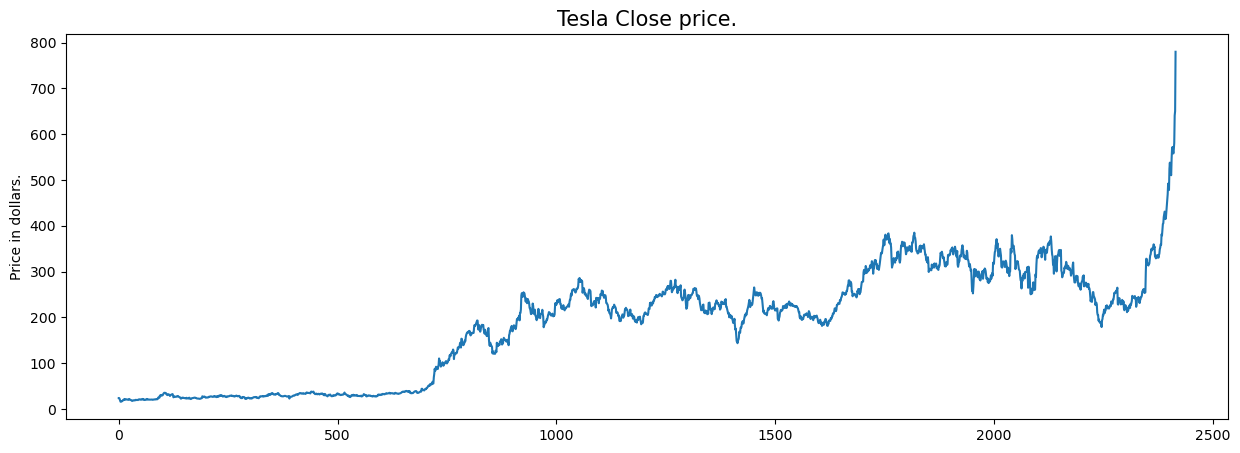

In [8]:
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Tesla Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [9]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,6/29/2010,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,6/30/2010,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,7/1/2010,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,7/2/2010,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,7/6/2010,20.000000,20.00,15.830000,16.110001,16.110001,6866900


#### The data in the ‘Close’ column and that available in the ‘Adj Close’ column is the same, check whether this is the case with each row or not.


In [10]:
df[df['Close'] == df['Adj Close']].shape

(2416, 7)

#### From here we can conclude that all the rows of columns ‘Close’ and ‘Adj Close’ have the same data. So, having redundant data in the dataset is not going to help so, we’ll drop this column before further analysis.

In [11]:
df = df.drop(['Adj Close'], axis=1)

In [12]:
df.head()

,Date,Open,High,Low,Close,Volume
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900


#### Check for the null values if any are present in the data frame.

In [13]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

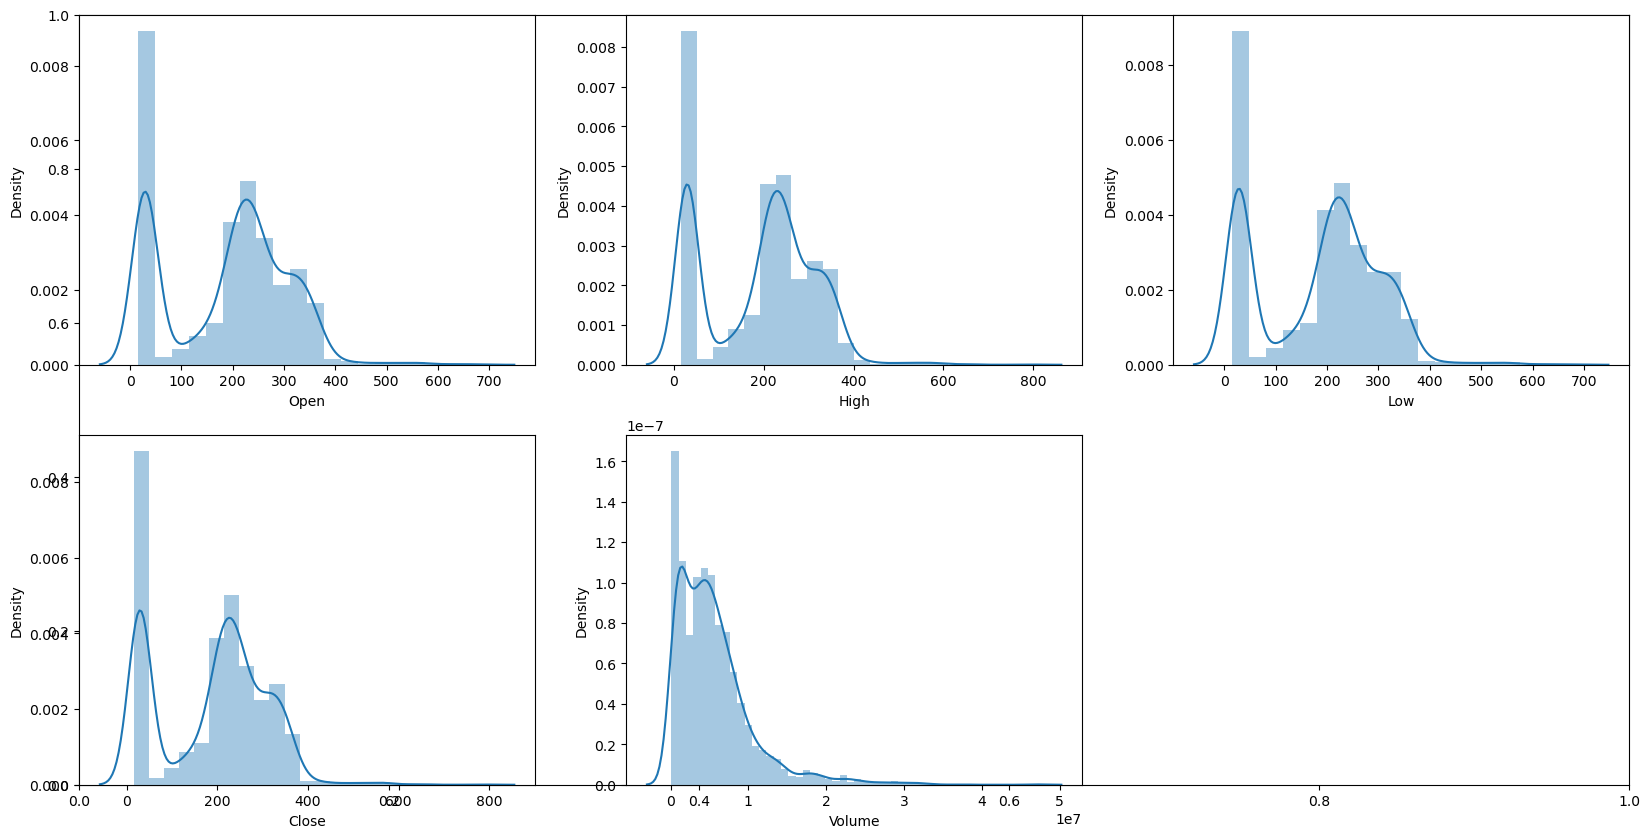

In [15]:
features=['Open', 'High', 'Low', 'Close', 'Volume']
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])

#### The two peaks depicts the data has varied significantly in two regions. And the Volume data is left-skewed.

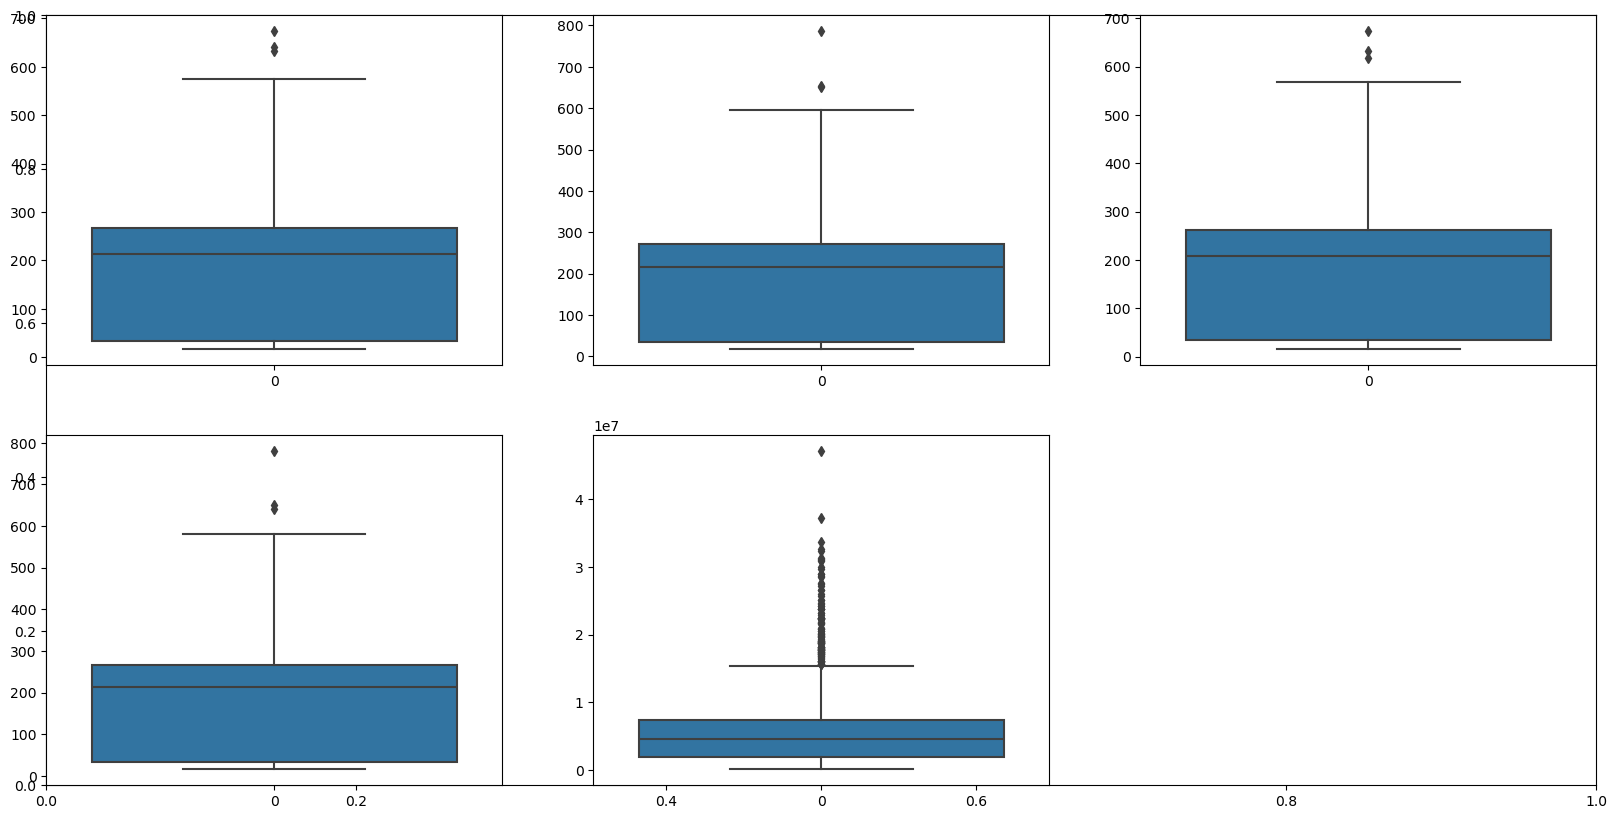

In [16]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()


#### Feature Engineering :

In [17]:
splitted = df['Date'].str.split('/', expand=True)

df['day'] = splitted[1].astype('int')
df['month'] = splitted[0].astype('int')
df['year'] = splitted[2].astype('int')

df.head()

,Date,Open,High,Low,Close,Volume,day,month,year
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,29,6,2010
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,30,6,2010
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,1,7,2010
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,2,7,2010
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,6,7,2010


In [18]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()


,Date,Open,High,Low,Close,Volume,day,month,year,is_quarter_end
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,29,6,2010,1
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,30,6,2010,1
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,1,7,2010,0
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,2,7,2010,0
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,6,7,2010,0


#### A quarter is defined as a group of three months. Every company prepares its quarterly results and publishes them publicly so, that people can analyze the company’s performance.

In [19]:
df['open-close'] = df['Open'] - df['Close']
df['low-high'] = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

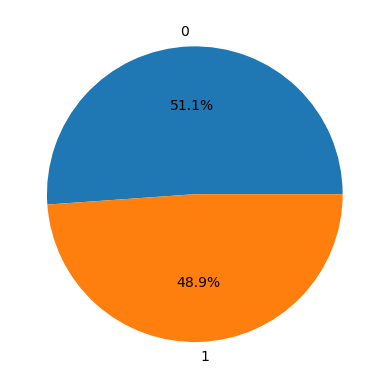

In [20]:
plt.pie(df['target'].value_counts().values, 
		labels=[0, 1], autopct='%1.1f%%')
plt.show()

#### Ensure that there are no highly correlated features as they do not help in the learning process of the algorithm.

In [22]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
	features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(2174, 3) (242, 3)


In [23]:
models = [LogisticRegression(), SVC(
kernel='poly', probability=True), XGBClassifier()]

for i in range(3): models[i].fit(X_train, Y_train)

print(f'{models[i]} : ')
print('Training Accuracy : ', metrics.roc_auc_score(
	Y_train, models[i].predict_proba(X_train)[:,1]))
print('Validation Accuracy : ', metrics.roc_auc_score(
	Y_valid, models[i].predict_proba(X_valid)[:,1]))
print()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9382749759754802
Validation Accuracy :  0.4496784345922277



In [24]:
y_pred = models[0].predict(X_valid)

# Create the confusion matrix
cm = metrics.confusion_matrix(Y_valid, y_pred)

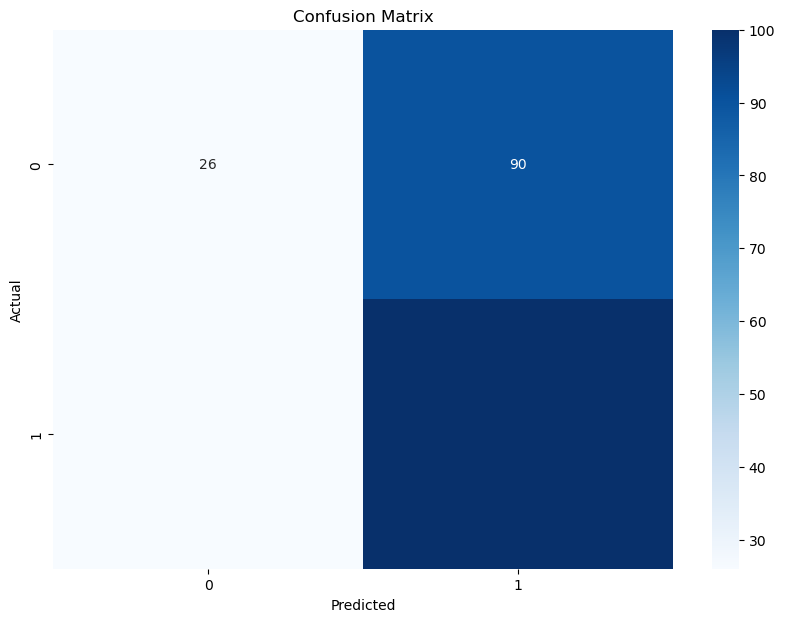

In [25]:
plt.figure(figsize=(10, 7))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()